In [1]:
import csv
import copy
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd


from Bio import SeqIO
from Bio.Seq import Seq

from matplotlib import pyplot as plt

/tmp/ipykernel_4371/3236037762.py:8: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

  import dask.dataframe as dd


In [2]:
def align_read(querystr,cigarstr,pattern=re.compile("[0-9]{0,10}[MDI]")):
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
#     output_str = "".join(["-" for i in range(cigar[1])])
    output_str = ""
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    return output_str
def cigarsfromsam(samfilepath):
    cigars = {}
    with open(samfilepath,"r") as samfile:
        for line in samfile:
            if line[0]=="@":
                next(samfile)
            else:
                splitline = line.split("\t")
                cigars[splitline[0]] = splitline[5]
    return cigars

def strsfromfasta(fastafilepath):
    queries = SeqIO.to_dict(SeqIO.parse(fastafilepath,"fasta"))
    queries = {key: str(val.seq) for key,val in queries.items()}
    return queries

def make_seg_dict(gfafile):
    segment_dict = {}
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                segment_dict[splitline[1]] = splitline[2][:-1]
    return segment_dict

def get_ref_intervals(gfafile):
    segment_dict = {}
    current_idx = 0
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                if "OFF" not in splitline[1]:
                    refstr = splitline[2][:-1]
                    strlen = len(refstr)
                    name = splitline[1]
                    if "ON" in name:
                        name=name[:-2]
                    segment_dict[name] = tuple((current_idx,current_idx+strlen))
                    current_idx += strlen
    return segment_dict
def align_read(querystr,refstr,cigarstr,startpos=1,pattern=re.compile("[0-9]{0,10}[MDI]")):
    start_pos = startpos-1 ##comes as 1 indexed from minimap
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
#     output_str = "".join(["-" for i in range(cigar[1])])
    output_str = ""
    if start_pos > 0:
        output_str += "".join(["-" for i in range(start_pos)])
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    remaining_len = len(refstr)-len(output_str)
    if remaining_len>0:
        output_str += "".join(["-" for i in range(remaining_len)])
    return output_str

def splitstr(instr,ref_intervals):    
    strassign = {key:instr[val[0]:val[1]] for key,val in ref_intervals.items()}
    return strassign

def slow_hamming_distance(s1, s2):
    if len(s1) != len(s2):
        print(s1,s2)
        raise ValueError("Strand lengths are not equal!")
    term_list = []
    for ch1,ch2 in zip(s1,s2):
        if ch1 == "N" or ch2 == "N":
            term_list.append(False)
        else:
            term_list.append(ch1 != ch2)
    result = sum(term_list)
    return result

def get_dict_dist(dict1,dict2):
    hamming_dict = {key:slow_hamming_distance(dict1[key],dict2[key]) for key in dict1.keys()}
    return hamming_dict

In [6]:
data = pd.read_csv("/home/de64/scratch/de64/sync_folder/2021-09-17_snakemake_lDE15_V2/output.tsv",delimiter="\t")
ref_intervals = get_ref_intervals("./aDE8_9.gfa")
barcodes = set(data["barcode"].tolist())

In [7]:
bit_arr = np.array([list(item) for item in barcodes]).astype('uint8')
bit_freq = np.mean(bit_arr,axis=0)

In [8]:
len(bit_freq)

30

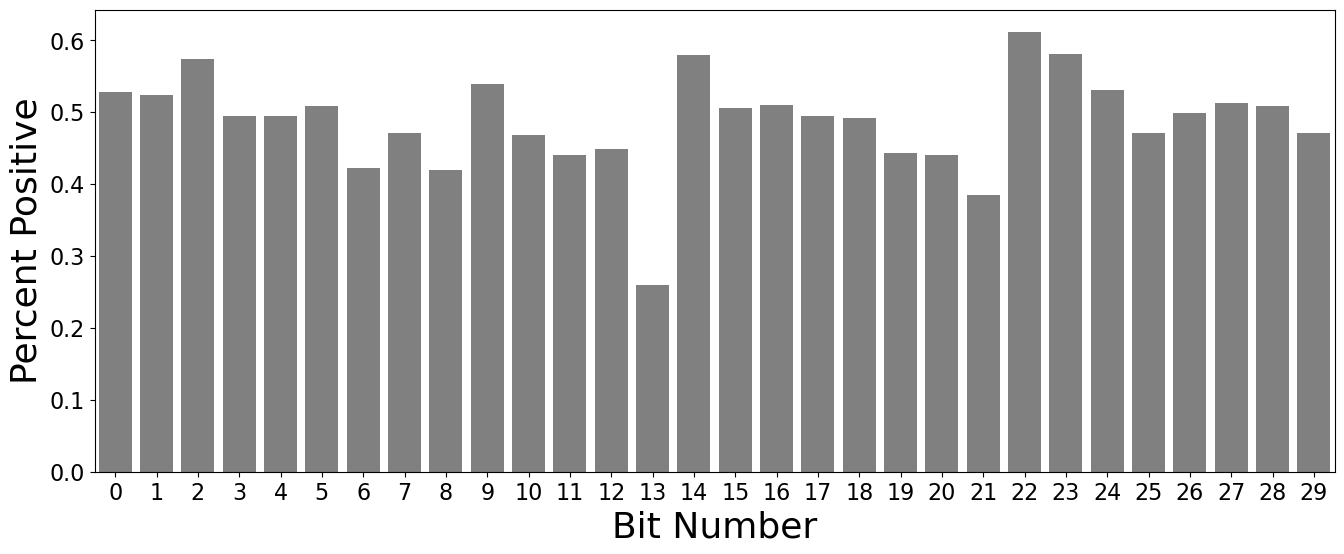

In [9]:
fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(range(len(bit_freq))), y=bit_freq, color="grey")
plt.xlabel("Bit Number",fontsize=26)
plt.ylabel("Percent Positive",fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("./bit_frequency.png",dpi=300,bbox_inches="tight")
plt.show()

In [11]:
import os
import shutil
import dask
import time
import h5py

from time import sleep
from dask.distributed import Client,progress
from dask_jobqueue import SLURMCluster
from IPython.core.display import display, HTML
import dask.array as da

def writedir(directory,overwrite=False):
    if overwrite:
        if os.path.exists(directory):
            shutil.rmtree(directory)
        os.makedirs(directory)
    else:
        if not os.path.exists(directory):
            os.makedirs(directory)

class dask_controller: #adapted from Charles' code
    def __init__(self,n_workers=6,local=True,queue="short",death_timeout=3.,\
                 walltime='01:30:00',cores=1,processes=1,memory='6GB',\
                 working_directory="./",job_extra=[]):
        self.local = local
        self.n_workers = n_workers
        self.walltime = walltime
        self.queue = queue
        self.death_timeout = death_timeout
        self.processes = processes
        self.memory = memory
        self.cores = cores
        self.working_directory = working_directory
        self.job_extra = job_extra

        writedir(working_directory,overwrite=False)

    def startdask(self):
        if self.local:
            self.daskclient = Client()
            self.daskclient.cluster.scale(self.n_workers)
        else:
            self.daskcluster = SLURMCluster(n_workers=self.n_workers,queue=self.queue,death_timeout=self.death_timeout,walltime=self.walltime,\
                                   processes=self.processes,memory=self.memory,\
                                  cores=self.cores,local_directory=self.working_directory,\
                                log_directory=self.working_directory,job_extra=self.job_extra)
#             self.workers = self.daskcluster.start_workers(self.n_workers)
            self.daskclient = Client(self.daskcluster)

    def shutdown(self):
        self.daskclient.restart()
        if not self.local:
            self.daskcluster.close()
        for item in os.listdir(self.working_directory):
            if "worker-" in item or "slurm-" in item or ".lock" in item:
                path = "./" + item
                if os.path.isfile(path):
                    os.remove(path)
                elif os.path.isdir(path):
                    shutil.rmtree(path)

    def printprogress(self):
        complete = len([item for item in self.futures if item.status=="finished"])
        print(str(complete) + "/" + str(len(self.futures)))

    def displaydashboard(self):
        link = self.daskcluster.dashboard_link
        display(HTML('<a href="' + link +'">Dashboard</a>'))

    def mapfovs(self,function,fov_list,retries=0):
        self.function = function
        self.retries = retries
        def mapallfovs(fov_number,function=function):
            function(fov_number)
        self.futures = {}
        for fov in fov_list:
            future = self.daskclient.submit(mapallfovs,fov,retries=retries)
            self.futures[fov] = future

    def retry_failed(self):
        self.failed_fovs = [fov for fov,future in self.futures.items() if future.status != 'finished']
        out = self.daskclient.restart()
        self.mapfovs(self.function,self.failed_fovs,retries=self.retries)

    def retry_processing(self):
        self.proc_fovs = [fov for fov,future in self.futures.items() if future.status == 'pending']
        out = self.daskclient.restart()
        self.mapfovs(self.function,self.proc_fovs,retries=self.retries)

/tmp/ipykernel_19606/3628947358.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [12]:
dask_controller = dask_controller(
    walltime="02:00:00",
    local=False,
    n_workers=50,
    memory="16GB",
    working_directory= "/home/de64/scratch/de64/dask",
)

dask_controller.startdask()

/home/de64/micromamba/envs/nanopore/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home/de64/micromamba/envs/nanopore/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41521 instead
  warnings.warn(
/home/de64/micromamba/envs/nanopore/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_dire

In [13]:
dask_controller.daskclient

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.120.16.236:41521/status,
Dashboard: http://10.120.16.236:41521/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.120.16.236:34307,Workers: 0
Dashboard: http://10.120.16.236:41521/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [14]:
dask_bit_arr = da.from_array(bit_arr,chunks=(10000,30)).astype("uint8")

In [15]:
dask_bit_arr

dask.array<array, shape=(125500, 30), dtype=uint8, chunksize=(10000, 30), chunktype=numpy.ndarray>

In [16]:
n_chunks = 5
step = dask_bit_arr.chunksize[0]*n_chunks

closest_match_list = []

for i in range(0,dask_bit_arr.shape[0],step):
    both_on = (dask_bit_arr[i:i+step]@dask_bit_arr.T).astype("uint8")
    both_off = ((-dask_bit_arr+1)[i:i+step]@(-dask_bit_arr.T+1)).astype("uint8")
    ttl_match = both_on+both_off
    hamming_dist = dask_bit_arr.shape[1] - ttl_match
    
    N = hamming_dist.shape[0]
    M = hamming_dist.shape[1]
    K = max(0,dask_bit_arr.shape[0]-(i+step))
    if (i>0) and (K>0):
        zeros_arr_left = da.zeros((N,i)).astype(bool)
        zeros_arr_right = da.zeros((N,K)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([zeros_arr_left,diagonal_mask,zeros_arr_right],axis=1)
    elif (i>0):
        zeros_arr_left = da.zeros((N,i)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([zeros_arr_left,diagonal_mask],axis=1)
    else:
        zeros_arr_right = da.zeros((N,K)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([diagonal_mask,zeros_arr_right],axis=1)
    
    hamming_dist[padded_diagonal_mask] = 100
    closest_match = da.min(hamming_dist,axis=1)
    closest_match_list.append(closest_match.compute())

closest_match_list = np.concatenate(closest_match_list)

In [17]:
with open("/home/de64/group/de64/nanopore/dev_notebooks/2021-09-16_snakemake_lDE15_v2/closest_match.npy", 'wb') as f:
    np.save(f, closest_match_list)

In [3]:
with open("/home/de64/group/de64/nanopore/dev_notebooks/2021-09-16_snakemake_lDE15_v2/closest_match.npy", 'rb') as f:
    closest_match_list = np.load(f)

In [19]:
closest_match_dict = {barcode:closest_match_list[k] for k,barcode in enumerate(barcodes)}

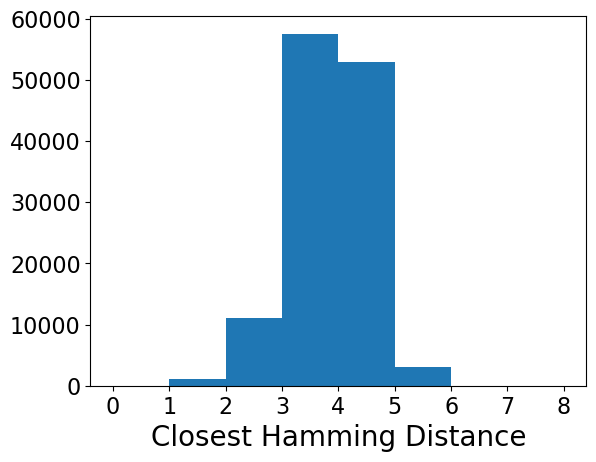

In [21]:
plt.hist(closest_match_list,bins=range(0,9))
plt.xlabel("Closest Hamming Distance",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("/home/de64/group/de64/nanopore/dev_notebooks/2021-09-16_snakemake_lDE15_v2/hamming_distribution.png",dpi=300,bbox_inches="tight")
plt.show()

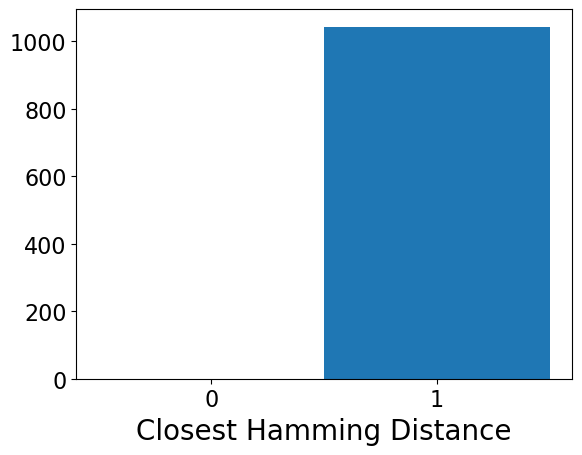

In [22]:
plt.hist(closest_match_list,range=(0,1),bins=2)
plt.xlabel("Closest Hamming Distance",fontsize=20)
plt.xticks([0.25,0.75],[0,1],fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("/home/de64/group/de64/nanopore/dev_notebooks/2021-09-16_snakemake_lDE15_v2/hamming_distribution_zoom.png",dpi=300,bbox_inches="tight")
plt.show()

### Depth Distribution

In [23]:
import pickle as pkl

with open('/home/de64/scratch/de64/sync_folder/2021-09-17_snakemake_lDE15_V2/graph_output/barcode_counts_dict.pkl', 'rb') as infile:
    depth_dict = pkl.load(infile)

In [25]:
depth_arr = np.array(list(depth_dict.values()))

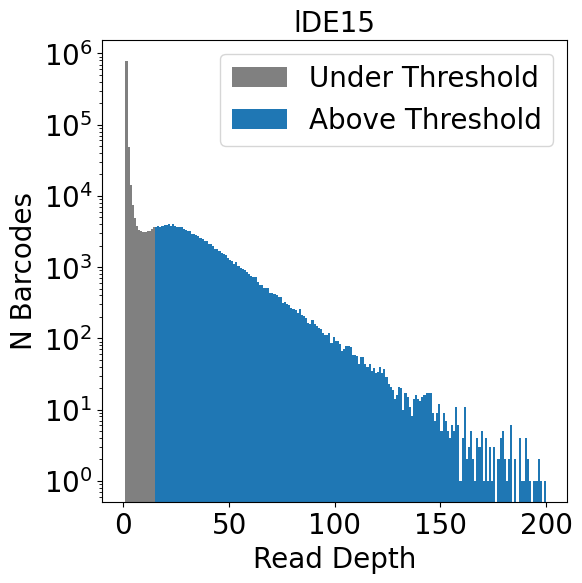

In [26]:
fig = plt.figure(figsize=(6, 6))

threshold=15

under_threshold_arr = depth_arr[depth_arr<threshold]
above_threshold_arr = depth_arr[depth_arr>=threshold]
plt.hist(under_threshold_arr, bins=200, range=(0,200), log=True, color="grey", label="Under Threshold")
plt.hist(above_threshold_arr, bins=200, range=(0,200), log=True, color="tab:blue", label="Above Threshold")
plt.xlabel("Read Depth",fontsize=20)
plt.xticks([0,50,100,150,200],fontsize=20)
plt.ylabel("N Barcodes",fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.title("lDE15",fontsize=20)
plt.savefig("/home/de64/group/de64/nanopore/dev_notebooks/2021-09-16_snakemake_lDE15_v2/depth_distribution.png",dpi=300,bbox_inches="tight")

In [27]:
len(closest_match_list)

125500

In [53]:
data_df = dd.from_pandas(data,npartitions=100).persist()

In [54]:
## Align consensus sequence to reference using cigar string
aligned_cons = data_df.apply(lambda x: align_read(x["consensus"],x["reference"],x["cigar"],startpos=x["alignmentstart"]), axis=1).persist()
## Use GFA reference to determine intervals for each annotation 
ref_intervals = get_ref_intervals("./aDE8_9.gfa")
## Split sequences based on annotated intervals
split_ref = data_df.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1).persist()
split_align = aligned_cons.apply(lambda x: splitstr(x,ref_intervals)).persist()

data_df["aligned_cons"] = aligned_cons
data_df["split_ref"] = split_ref
data_df["split_align"] = split_align

## Compute hamming distance from reference, by annotated element
hamm_ref = data_df.apply(lambda x: get_dict_dist(x["split_align"],x["split_ref"]), axis=1, meta=dict).persist()
## Get hamming distance from reference of the nucleotides which vary in the library, to determine GFP vs DarkGFP
dark_gfp = (data_df.apply(lambda x: slow_hamming_distance(x["split_align"]["Variant"][623:625],x["split_ref"]["Variant"][623:625]), axis=1, meta=int)>0).persist()
## Assign closest match to each barcode (for costructing output df later)
closest_hamming_dist = data_df["barcode"].compute().apply(lambda x: closest_match_dict[x])

data_df["hamm_ref"] = hamm_ref
data_df["dark_gfp"] = dark_gfp
data_df["Closest Hamming Distance"] = closest_hamming_dist
data_df = data_df.persist()

del hamm_ref
del dark_gfp
del closest_hamming_dist
del aligned_cons
del split_align
del split_ref

data_df = data_df.compute()

/home/de64/miniconda3/envs/nanopore/lib/python3.6/site-packages/dask/dataframe/core.py:4487: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))
/home/de64/miniconda3/envs/nanopore/lib/python3.6/site-packages/dask/dataframe/core.py:4487: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, me

In [ ]:
## Storing dataframe as a csv
data_df.to_csv("/home/de64/group/de64/nanopore/dev_notebooks/2021-09-16_snakemake_lDE15_v2/lDE15_final_df.tsv",sep="\t")

In [31]:
data_df = pd.read_csv("/home/de64/group/de64/nanopore/dev_notebooks/2021-09-16_snakemake_lDE15_v2/lDE15_final_df.tsv",sep="\t")

In [32]:
GFP_freq = np.unique(data_df["dark_gfp"],return_counts=True)[1]/data_df["dark_gfp"].size

In [36]:
n_gfp = np.sum(~data_df["dark_gfp"])
n_dark = np.sum(data_df["dark_gfp"])

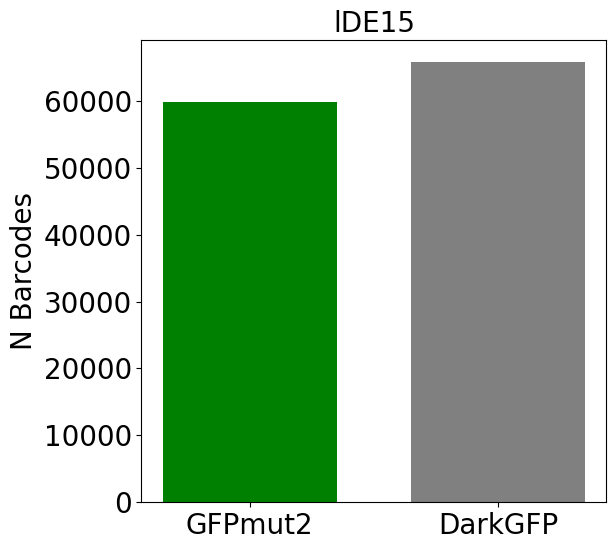

In [56]:
fig = plt.figure(figsize=(6, 6))

plt.bar([0,1],[n_gfp,n_dark],color=["green","grey"],width=0.7)
plt.xticks(ticks=[0,1],labels=["GFPmut2","DarkGFP"],fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("N Barcodes",fontsize=20)
plt.title("lDE15",fontsize=20)
plt.savefig("/home/de64/group/de64/nanopore/dev_notebooks/2021-09-16_snakemake_lDE15_v2/barcodes_per_gfp.png",dpi=300,bbox_inches="tight")